# Classifying Non Profit Donor Strategy from Cultivating Volunteers


## EDA and Pre-Processing

**Sanjay Regi Philip and Maha Jayapal**

**Applied Data Science**

**Masterâ€™s Program**

**Shiley Marcos School of Engineering/ University of San Diego**

**sregiphilip@sandiego.edu | mjayapal@sandiego.edu**

### Purpose:
The purpose of this analytical research project is to leverage non profit volunteer databases to identify individuals who are likely to be high-level donors.
As volunteer and donor data is highly sensitive information and a prized asset of non profit organizations, this research project uses data that is freely available and provided by the United States census which will need to be processed to only include features relevant for the topic of this research project.

### Data Retrieved from: 

https://archive.ics.uci.edu/ml/datasets/census+income 

## Load Necessary Packages

In [56]:
import pandas as pd
import numpy as np 
import seaborn as sns

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Data Input

In [2]:
## Remember to replace with your local filepath
census = pd.read_csv('/Users/sanjay/Library/CloudStorage/OneDrive-Personal/USD/ADS599/Data/census.csv')

In [3]:
## Verify data was read correctly
census.head(5)

age  workclass  fnlwgt     education  education-num      marital-status  \
0   25    Private  226802          11th              7       Never-married   
1   38    Private   89814       HS-grad              9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm             12  Married-civ-spouse   
3   44    Private  160323  Some-college             10  Married-civ-spouse   
4   18          ?  103497  Some-college             10       Never-married   

          occupation relationship   race     sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country income  
0              40  United-States  <=50K  
1              50  United-States  <=50K  
2              40  United-States   >50K  
3              40  United-States   >50K  
4              30  United-States  <=50K

In [4]:
## Dimensions of Dataset before any processing
census.shape

(48842, 15)

In [5]:
## Verify datatypes of columns in dataset
census.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

## Initial Data Preparation

### Remove Unnecessary Columns
As this project uses a census dataset, features will need to be dropped that are not likely to be available for non profit organizations to use.

In [6]:
## keep copy of original dataframe in case we need to revert back later
census_original = census

In [7]:
## drop columns that are not likely to be valuable or relevant
census = census.drop(columns=['fnlwgt','education-num', 'capital-gain', 'capital-loss', 'hours-per-week',
                             'occupation', 'relationship', 'race'])

### Check for null values

In [8]:
census.isna().sum()

age               0
workclass         0
education         0
marital-status    0
sex               0
native-country    0
income            0
dtype: int64

The dataset seems to have no blank or null values but instead null values have later been observed denoted by '?'.

#### Impute '?' values

In [13]:
## identify records with a '?' null value
census_string = census[['workclass', 'education', 'marital-status',
                       'sex', 'native-country', 'income']]

question_counts = census_string.apply(lambda x: x.str.count('\?')).sum()
question_counts

workclass         2799
education            0
marital-status       0
sex                  0
native-country     857
income               0
dtype: int64

As the number of '?' values were relatively low compared to the length of the dataframe, we choose to drop the rows where there is a '?' value as there is no other clear way to impute the value.

In [15]:
## drop '?' values
census = census.drop(census.loc[census['workclass'] == '?'].index)
census = census.drop(census.loc[census['native-country'] == '?'].index)

In [17]:
## shape of the dataset after removing the null values
census.shape

(45232, 7)

3656 rows were dropped to account for null values

## Exploratory Data Analysis

### Univariate Analysis
Explore the properties of each individual feature

In [24]:
age = census['age']
age.describe()

count    45232.000000
mean        38.543819
std         13.219436
min         17.000000
25%         28.000000
50%         37.000000
75%         47.000000
max         90.000000
Name: age, dtype: float64

array([[<AxesSubplot: title={'center': 'age'}>]], dtype=object)

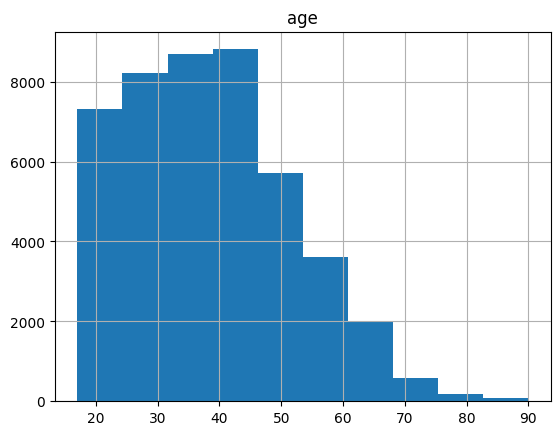

In [25]:
census.hist(column='age')

This analysis shows that the individuals in the given dataset has a mean of 38.54 years old and a range of 17-90 years old. The histogram additionally shows a right skew with a large proportion of the individuals on the younger side of the range with the 50% percentile at 37 years old.

#### Income

In [26]:
## This project will be using income as the indicator for if someone is likely to be a mid-level or high-level donor
census['income'] = census['income'].replace({'<=50K': 'Mid-Level', '>50K': 'High-Level'})

Mid-Level     34024
High-Level    11208
Name: income, dtype: int64


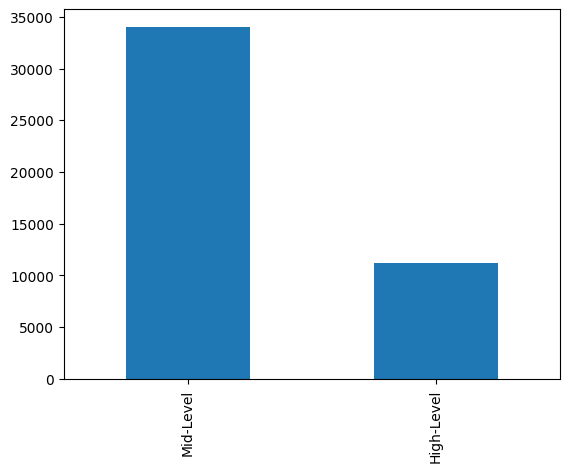

In [27]:
income_counts = census['income'].value_counts()

print(census['income'].value_counts())

income_counts.plot.bar()

plt.show()

In [28]:
count_mid = (census['income'] == 'Mid-Level').sum()

prop_mid = count_mid / len(census['income'])

round(prop_mid,2)

0.75

This dataset appears to be constructed with 75% of individuals being classified under the Mid-Level donor definition. This means that the target class of High-Level will be a minority class in this analysis and that there is a class imbalance that must be considered for this analysis.

#### Workclass

Private             33307
Self-emp-not-inc     3796
Local-gov            3100
State-gov            1946
Self-emp-inc         1646
Federal-gov          1406
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64


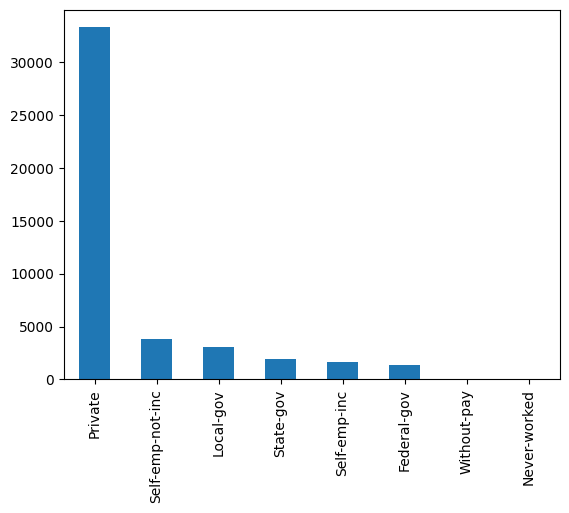

In [30]:
workclass_counts = census['workclass'].value_counts()

print(census['workclass'].value_counts())

workclass_counts.plot.bar()

plt.show()

In [31]:
count_priv = (census['workclass'] == 'Private').sum()

count_priv

prop_priv = count_priv / len(census['workclass'])

round(prop_priv,2)

0.74

About 74% of individuals in this analysis work as part of the private sector again showing another class imbalance. There also appears to be many different categories of work class that are fairly similar (government jobs, not currently working, etc) which can probably be combined together.

#### Marital Status

Married-civ-spouse       21056
Never-married            14605
Divorced                  6298
Separated                 1411
Widowed                   1277
Married-spouse-absent      553
Married-AF-spouse           32
Name: marital-status, dtype: int64


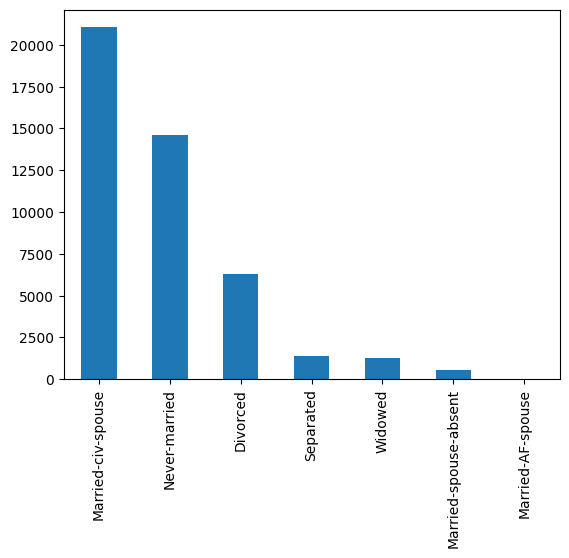

In [32]:
counts = census['marital-status'].value_counts()

print(census['marital-status'].value_counts())

counts.plot.bar()

plt.show()

Similar to working class, marital status appears to have many categories that can be combined. As is, married with a civilian spouse seems to be the largest class.

#### Sex

Male      30534
Female    14698
Name: sex, dtype: int64


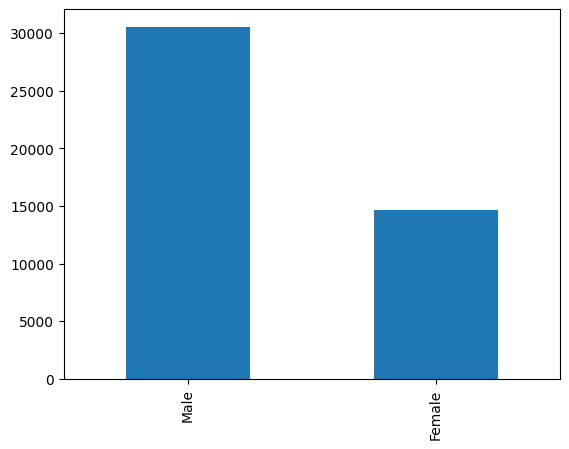

In [33]:
counts = census['sex'].value_counts()

print(census['sex'].value_counts())

counts.plot.bar()

plt.show()

In [34]:
count = (census['sex'] == 'Male').sum()

prop = count / len(census['sex'])

round(prop,2)

0.68

68% of individuals in this dataset are Male which shows another class imbalance as it comes to the sex of individuas in this dataset.

#### Native Country

In [35]:
count = (census['native-country'] == 'United-States').sum()

prop = count / len(census['native-country'])

round(prop,2)

0.91

There are many different native countries for individuals in this dataset but the vast majority of individuals are from the United States compromising 91% of individuals in the dataset.

### Bivariate Analysis

<AxesSubplot: xlabel='sex', ylabel='count'>

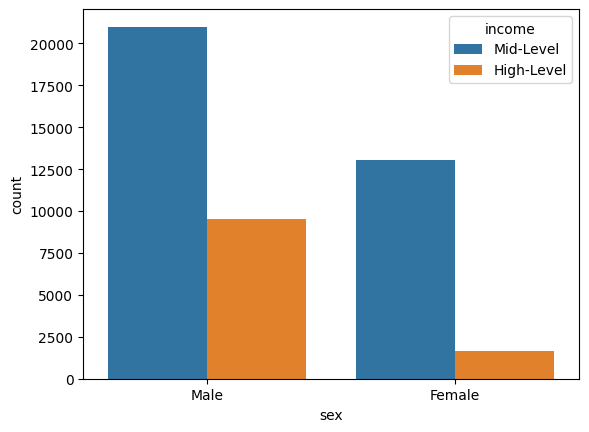

In [38]:
## Sex and Income
sns.countplot(x='sex', hue='income', data = census)

There appears to be a larger difference in the ratio of high level to mid level individuals for females than there are for males.

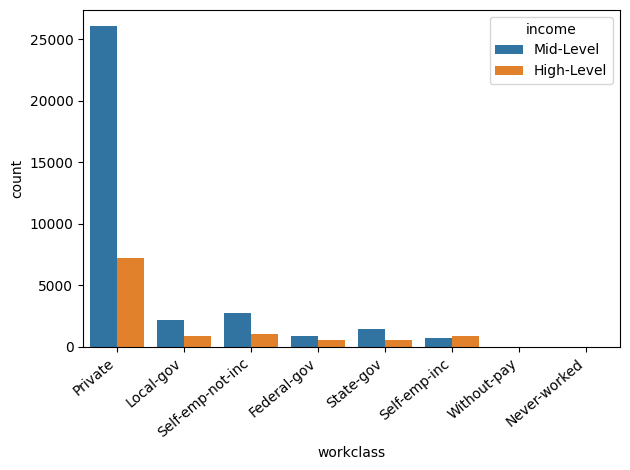

In [39]:
## Workclass and Income

ax = sns.countplot(x='workclass' , hue='income', data = census)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

The self employed work class is the only workclass where there are more high level individuals than there are mid level.

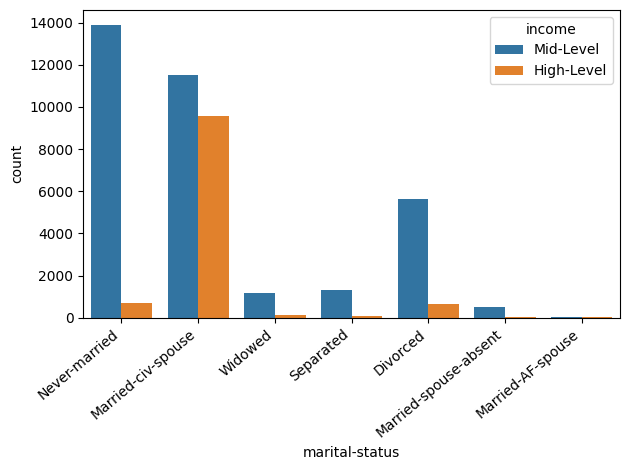

In [40]:
## Marital Status and Income

ax = sns.countplot(x='marital-status' , hue='income', data = census)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

The married with a civilian spouse marital status class has almost as many high-level individuals as mid level individuals. The other classes have dramatically higher disparities.

## Pre-processing

### Normalization and Standardization of Categorical Variables
Comibining similar classes in the categorical features that will be used for the analysis in order to make the results more interpretable.

#### Marital-Status

Combining the rows in the marial-status of Married-civ-spouse, Married-spouse-absent, and Married-AF-spouse to Married

In [42]:
census['marital-status'].value_counts()

Married-civ-spouse       21056
Never-married            14605
Divorced                  6298
Separated                 1411
Widowed                   1277
Married-spouse-absent      553
Married-AF-spouse           32
Name: marital-status, dtype: int64

In [43]:
census['marital-status'] = census['marital-status'].replace({'Married-civ-spouse': 'Married', 
                                  'Married-spouse-absent': 'Married', 
                                  'Married-AF-spouse': 'Married'})
census['marital-status'].value_counts()

Married          21641
Never-married    14605
Divorced          6298
Separated         1411
Widowed           1277
Name: marital-status, dtype: int64

In [44]:
census['marital-status'] = census['marital-status'].replace({'Never-married': 'Single', 
                                  'Divorced': 'Single','Separated': 'Single', 'Widowed': 'Single'})
census['marital-status'].value_counts()

Single     23591
Married    21641
Name: marital-status, dtype: int64

We only have two marital status classes which are very similar in frequency in this dataset.

#### Workclass

In [46]:
census['workclass'].value_counts()

Private             33307
Self-emp-not-inc     3796
Local-gov            3100
State-gov            1946
Self-emp-inc         1646
Federal-gov          1406
Without-pay            21
Never-worked           10
Name: workclass, dtype: int64

In [47]:
census['workclass'] = census['workclass'].replace({'Local-gov': 'Government', 
                                                   'Federal-gov': 'Government', 
                                                   'State-gov': 'Government',
                                                   
                                                   'Self-emp-not-inc': 'Self-emp',
                                                   'Self-emp-inc': 'Self-emp',
                                                   
                                                   'Without-pay': 'No-income',
                                                   'Never-worked': 'No-income',
                                                   
                                                   '?': 'Unknown'})

census['workclass'].value_counts()

Private       33307
Government     6452
Self-emp       5442
No-income        31
Name: workclass, dtype: int64

With data preparation, the number of classes within workclass was able to be simplified to only 4 classes with Private still being the largest work class.

#### Native Country

In [48]:
census['native-country'] = np.where((census['native-country'] != 'United-States') & 
                                    (census['native-country'] != '?'), 'Non-US', census['native-country'])

census['native-country'] = census['native-country'].replace({'?': 'Unknown'})

census['native-country'].value_counts()

United-States    41302
Non-US            3930
Name: native-country, dtype: int64

As the list of different native countries was extremely long but with the United States being the Native Country for the vast majority of individuals, all non-US countries were grouped together to simplify the number of classes.

#### Education

In [49]:
census['education'].value_counts()

HS-grad         14785
Some-college     9901
Bachelors        7570
Masters          2514
Assoc-voc        1959
11th             1622
Assoc-acdm       1507
10th             1225
7th-8th           824
Prof-school       785
9th               676
12th              577
Doctorate         544
5th-6th           449
1st-4th           222
Preschool          72
Name: education, dtype: int64

In [50]:
census['education'] = census['education'].replace({'10th': 'DNF HS', 
                                                   '7th-8th': 'DNF HS', 
                                                   '9th': 'DNF HS',
                                                   '11th': 'DNF HS', 
                                                   '9th': 'DNF HS',
                                                   '12th': 'DNF HS', 
                                                   '5th-6th': 'DNF HS',
                                                   '1st-4th': 'DNF HS', 
                                                   'Preschool': 'DNF HS',
                                                  
                                                   'HS-grad': 'HS',
                                                   'Some-college': 'HS',
                                                   
                                                   'Assoc-voc': 'Assoc',
                                                   'Assoc-acdm': 'Assoc'})

census['education'].value_counts()

HS             24686
Bachelors       7570
DNF HS          5667
Assoc           3466
Masters         2514
Prof-school      785
Doctorate        544
Name: education, dtype: int64

The number of education categories in the original dataset was very long and difficult to interpret. To solve for this, we grouped together all the education categories that did not finish high school into DNF HS (Did not finish High School), as we grouped together all individuals who finished high school but not college, and those that completed an associate's degree.

### One Hot Encoding
Most classification models require that categorical features be hot encoded with a numerical value.

In [51]:
## saving a new dataframe with one hot encoding for categorical features
census_encoded = pd.get_dummies(data=census, columns=['workclass', 'education', 'marital-status', 'sex',
                                                     'native-country'])

In [52]:
census_encoded.columns

Index(['age', 'income', 'workclass_Government', 'workclass_No-income',
       'workclass_Private', 'workclass_Self-emp', 'education_Assoc',
       'education_Bachelors', 'education_DNF HS', 'education_Doctorate',
       'education_HS', 'education_Masters', 'education_Prof-school',
       'marital-status_Married', 'marital-status_Single', 'sex_Female',
       'sex_Male', 'native-country_Non-US', 'native-country_United-States'],
      dtype='object')

In [53]:
## must remove one encoded column to avoid multicollinearity due to dummy variable trap
census_encoded = census_encoded.drop(columns=['workclass_Private', 'education_HS', 
                                             'marital-status_Single', 'sex_Male',
                                             'native-country_United-States'])

In [54]:
census_encoded.head(5)

age      income  workclass_Government  workclass_No-income  \
0   25   Mid-Level                     0                    0   
1   38   Mid-Level                     0                    0   
2   28  High-Level                     1                    0   
3   44  High-Level                     0                    0   
5   34   Mid-Level                     0                    0   

   workclass_Self-emp  education_Assoc  education_Bachelors  education_DNF HS  \
0                   0                0                    0                 1   
1                   0                0                    0                 0   
2                   0                1                    0                 0   
3                   0                0                    0                 0   
5                   0                0                    0                 1   

   education_Doctorate  education_Masters  education_Prof-school  \
0                    0                  0                      0   
1                    0                  0                      0   
2                    0                  0                      0   
3                    0                  0                      0   
5                    0                  0                      0   

   marital-status_Married  sex_Female  native-country_Non-US  
0                       0           0                      0  
1                       1           0                      0  
2                       1           0                      0  
3                       1           0                      0  
5                       0           0                      0

## Train/ Test Split

In [59]:
train, test = train_test_split(census_encoded, test_size=0.2, random_state=42, stratify=census_encoded['income'])

In [61]:
train.shape

(36185, 14)

In [62]:
test.shape

(9047, 14)